### This notebook extracts data that is required by the turbulence model to run
1. Identify potential water columns of interest - begin with the FRIS sill
1. Get vertical density profile of profiles of interest
1. Get pressure gradient $\nabla_{x,y} P$ between profiles of interest and points that are to the north and to the east. Ensure that there is less time interval between measurement of these water columns to make the gradient accurate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point

<IPython.core.display.Javascript object>


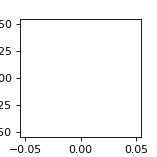

In [560]:
%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

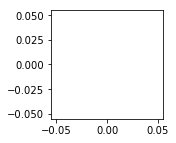

In [557]:
%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

In [4]:
dfmg = pd.read_csv("dfmg_glDist.csv")
del dfmg['Unnamed: 0']
del dfmg['Unnamed: 0.1']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])

In [578]:
import plot_stations as pltStn
import importlib
importlib.reload(pltStn)

<module 'plot_stations' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_stations.py'>

In [6]:
import plot_bathy as pltBathy
import importlib
importlib.reload(pltBathy)

<module 'plot_bathy' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_bathy.py'>

In [7]:
import find_depth_averages_v2 as averageProfile
import plot_var_contours_with_distance as plt2dDepthVsDist

In [268]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

In [269]:
def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

WSO_source = get_mask_from_prof_mask(dfmg, WSO_source)
WSO_prod = get_mask_from_prof_mask(dfmg, WSO_prod)

In [9]:
import plot_station_bot_sal as pbs

In [10]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

In [12]:
box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 80)

In [13]:
Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8)
Prydz = (box9 | box10)
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea

In [14]:
dfmg['mab'] = abs(dfmg['ECHODEPTH'] - dfmg['DEPTH'])
lt60 = abs(dfmg['mab']) < 60
lt100 = abs(dfmg['mab']) < 100
lt200 = abs(dfmg['mab']) < 200

In [15]:
lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_GLINE'] <= 50
gline_le_100km = dfmg['DIST_GLINE'] <= 100
gline_le_150km = dfmg['DIST_GLINE'] <= 150
gline_le_25km = dfmg['DIST_GLINE'] <= 25

In [16]:
def play_beep():
    import os
    duration = 0.5  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))
play_beep()

In [530]:
year_mask = dfmg.loc[:, 'JULD'].dt.year == 2011
month_mask = dfmg.loc[:, 'JULD'].dt.month == 3

mask_selection = year_mask & month_mask & Weddell & WSO_source
time_vector = dfmg.loc[dfmg.loc[mask_selection].\
                       groupby('PROFILE_NUMBER').head(1).index, 'JULD'].astype(pd.datetime).values

profile_numbers = dfmg.loc[dfmg.loc[mask_selection].\
                           groupby('PROFILE_NUMBER').head(1).index, 'PROFILE_NUMBER'].values

sorted_indices = np.argsort(time_vector)
time_vector = time_vector[sorted_indices]
profile_numbers = profile_numbers[sorted_indices]
diff = np.diff(time_vector)
for i in range(len(diff)):
    diff[i] = diff[i].total_seconds()/3600.
len(diff)

677

In [584]:
len(profile_numbers[np.where(diff <= 1)[0]])

447

In [532]:
diff_indices_le1 = np.where(diff <= 1)[0]

In [533]:
np.where((diff_indices_le1[1:] - diff_indices_le1[:-1]) == 1)

(array([  0,   1,   2,   3,   4,   5,   7,   8,   9,  11,  12,  14,  15,
         16,  18,  19,  21,  22,  23,  24,  25,  27,  28,  29,  30,  31,
         33,  34,  35,  36,  38,  39,  40,  42,  44,  45,  46,  47,  48,
         50,  51,  52,  53,  54,  55,  57,  58,  59,  60,  63,  65,  66,
         67,  68,  69,  71,  72,  73,  75,  76,  78,  81,  83,  84,  85,
         86,  87,  88,  90,  91,  92,  93,  94,  95,  96,  97,  99, 100,
        101, 102, 103, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115,
        116, 118, 121, 123, 124, 126, 127, 128, 130, 131, 134, 135, 136,
        137, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152,
        153, 154, 155, 157, 158, 159, 161, 162, 163, 164, 165, 166, 168,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183,
        187, 188, 189, 191, 192, 193, 194, 195, 197, 199, 200, 201, 203,
        204, 205, 207, 208, 209, 210, 212, 214, 216, 218, 219, 221, 222,
        223, 225, 227, 228, 234, 235, 236, 237, 238

In [534]:
diff_indices_le1[0:10]

array([ 3,  4,  5,  6,  7,  8,  9, 11, 12, 13])

In [535]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [651]:
consec = consecutive(diff_indices_le1)
streak_len = np.zeros(len(consec))
for i in range(len(consec)):
    streak_len[i] = len(consec[i])
np.argsort(streak_len)

array([111,  72,  27,  69,  68,  32, 126, 116, 124, 117,  62, 121, 118,
        42,  43,  60, 120,  59,  58,  57,  74,  77,  73,  96, 136, 114,
        82, 134,  13,  94,  97,  91,  87, 105, 106, 107,  19, 112,  83,
       139,  99, 103,  76,  64,  89, 140,  71,  84,  52,  63,  51,  70,
       119, 137,   9,  14,  18,  20, 132,  50, 128,  26,  28,  34,  55,
       122,  46,  39, 123,  17, 133,  93, 110,  95, 135,  98, 100, 101,
        53, 138,   4,   2,  86,  85,  88,  67,  31,  29,  75,  56,  48,
         1, 108,   3, 113,  30,  41, 127,   8,  44, 131,  78,  92, 115,
        90,  16,  37,  80,  47,  54,  81, 130, 141,   7, 102,  24,  33,
        12,  49,  36, 109,  10,  25,  45,   6,   5,  66,  79,  15,  11,
        21,   0, 129, 125,  38,  61,  65,  23, 104,  22,  35,  40])

In [653]:
streak_len[40]

11.0

In [654]:
profile_numbers[consec[40]]

array([259580, 261295, 259081, 260784, 256594, 257904, 260219, 258599,
       256595, 261296, 259082])

<IPython.core.display.Javascript object>


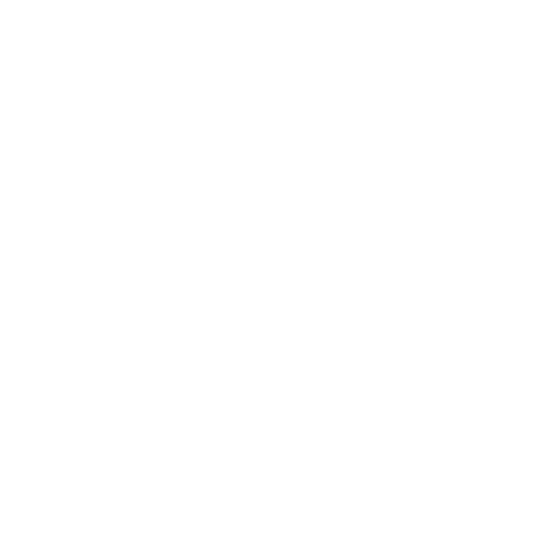

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [579]:
profs = profile_numbers[np.where(diff <= 1)[0]][0:10]
mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
positions = dfmg.loc[dfmg[mask].groupby('PROFILE_NUMBER').tail(1).index, 'LATITUDE':'LONGITUDE'].values
markers = dfmg.loc[dfmg[mask].groupby('PROFILE_NUMBER').tail(1).index, 'PROFILE_NUMBER'].values
pltStn.plot_station_locations(positions, title='Profile Locations', wd=7, ht=7, 
                              region='Weddell', markers=markers)

In [599]:
def print_prof_details(dfmg, selected_profs):
    mask_sel_profiles = dfmg.loc[:, 'PROFILE_NUMBER'].isin(selected_profs)
    dfmg.loc[dfmg[mask_sel_profiles].groupby('PROFILE_NUMBER').head(1).index, 
                  'JULD':'PROFILE_NUMBER'].head(len(selected_profs))
    #print(dfmg.loc[dfmg.loc[dfmg[mask_sel_profiles].groupby('PROFILE_NUMBER').head(1).index, 
    #              'JULD'].sort_values().index, 'PROFILE_NUMBER'].values)

In [659]:
# [256650, 256649, 256648, 256651, 263107, 263106]
# [256586, 256587, 256588]
# [256573, 256574]
# [256580, 256581, 256582, 256583]
# [259576, 259577, 259578]
#[259550, 259575]
#array([257898, 259575, 256589, 258595, 259075, 261291, 259076, 256590, 261292, 258596, 257899])

selected_profiles1 = np.array([259580, 261295, 259081, 260784, 256594, 257904, 260219, 258599,
       256595, 261296, 259082])
mask_sel_profiles = dfmg.loc[:, 'PROFILE_NUMBER'].isin(selected_profiles1)
dfmg.loc[dfmg[mask_sel_profiles].groupby('PROFILE_NUMBER').head(1).index, 
                  'JULD':'PROFILE_NUMBER'].head(len(selected_profiles1))
#print_prof_details(dfmg, selected_profiles1)

,JULD,LATITUDE,LONGITUDE,PLATFORM_NUMBER,POSITION_QC,PRES_ADJUSTED,PRES_ADJUSTED_QC,PROFILE_NUMBER
1823350,2011-03-08 07:14:00.009600000,-74.5541,-41.2675,b'00021108',b'1',8.0,1,256594
1823370,2011-03-08 09:18:00.000000000,-74.5575,-41.2089,b'00021108',b'1',8.0,1,256595
1849408,2011-03-08 07:32:00.009599999,-75.8949,-35.1986,b'00021090',b'1',8.0,1,257904
1858308,2011-03-08 08:42:00.000000000,-75.0435,-37.7150,b'00021120',b'1',8.0,1,258599
1867928,2011-03-08 06:49:59.980799999,-77.0254,-42.3926,b'00021036',b'1',8.0,1,259081
1867948,2011-03-08 09:26:00.038400000,-77.0185,-42.4463,b'00021036',b'1',8.0,1,259082
1877868,2011-03-08 06:24:00.028800000,-74.6159,-40.5952,b'00021126',b'1',8.0,1,259580
1890623,2011-03-08 07:48:00.000000000,-76.5626,-36.7673,b'00021030',b'1',8.0,1,260219
1901903,2011-03-08 06:58:00.019200000,-73.9864,-39.7768,b'00021048',b'1',8.0,1,260784
1911981,2011-03-08 06:45:59.961599999,-77.3052,-45.0929,b'00021042',b'1',8.0,1,261295


In [543]:
dfmg.loc[dfmg.loc[:, 'PROFILE_NUMBER'].isin(selected_profiles1)].groupby(
'PROFILE_NUMBER').tail(1)

,JULD,LATITUDE,LONGITUDE,PLATFORM_NUMBER,POSITION_QC,PRES_ADJUSTED,PRES_ADJUSTED_QC,PROFILE_NUMBER,PSAL_ADJUSTED,PSAL_ADJUSTED_QC,...,TEMP_ADJUSTED_QC,DEPTH,DENSITY_INSITU,POT_DENSITY,CTEMP,DENSITY_GRADIENT,ECHODEPTH,mab,deep_flag,DIST_GLINE
1823089,2011-03-04 21:08:00.038400,-74.7062,-41.5779,b'00021108',b'1',356.0,1,256580,34.619999,1,...,1,-352.003863,1029.590919,27.880646,-1.829941,-0.000010,-356.0,3.996137,1.0,400.469293
1823109,2011-03-05 07:00:00.028800,-74.6979,-41.6017,b'00021108',b'1',358.0,1,256581,34.615799,1,...,1,-353.979843,1029.596305,27.876678,-1.809962,0.000092,-355.0,1.020157,1.0,401.299429
1823129,2011-03-05 09:22:00.019200,-74.6967,-41.5936,b'00021108',b'1',330.0,1,256582,34.618000,1,...,1,-326.316334,1029.463763,27.878165,-1.807471,-0.000611,-355.0,28.683666,1.0,401.460927
1823149,2011-03-05 13:05:59.971200,-74.6947,-41.5778,b'00021108',b'1',311.0,1,256583,34.606998,1,...,1,-307.542558,1029.360251,27.866481,-1.718694,-0.001810,-356.0,48.457442,1.0,401.738612


In [144]:
selected_profiles2 = [259646, 259645, 259644, 259643]
print_prof_details(dfmg, selected_profiles2)

['2011-03-21T07:27:59.990400000' '2011-03-21T09:42:00.028800000'
 '2011-03-21T13:02:00.038400000' '2011-03-21T17:14:00.038400000']
[259643 259644 259645 259646]


In [145]:
selected_profiles3 = [259143, 259142, 259141, 259140]
print_prof_details(dfmg, selected_profiles3)

['2011-03-21T06:22:00.019200000' '2011-03-21T11:03:59.990400000'
 '2011-03-21T14:14:00.038400000' '2011-03-21T21:24:00.028800000']
[259140 259141 259142 259143]


In [146]:
selected_profiles4 = [255871, 255872, 255873, 255874]
print_prof_details(dfmg, selected_profiles4)

['2011-03-21T08:19:59.980799999' '2011-03-21T12:49:59.980800000'
 '2011-03-21T16:14:00.009600000' '2011-03-21T20:14:00.038400000']
[255871 255872 255873 255874]


In [485]:
import xarray as xr
U10 = xr.open_dataset("/media/data/Datasets/ESRL_U10/uwnd.10m.gauss.2011.nc")
V10 = xr.open_dataset("/media/data/Datasets/ESRL_U10/vwnd.10m.gauss.2011.nc")

In [486]:
V10.variables

Frozen(OrderedDict([('lat', <xarray.Coordinate 'lat' (lat: 94)>
array([ 88.54199982,  86.65309906,  84.75319672,  82.85079956,
        80.94730377,  79.04350281,  77.13939667,  75.23509979,
        73.33070374,  71.42620087,  69.521698  ,  67.61710358,
        65.71250153,  63.80789948,  61.90330124,  59.99860001,
        58.09389877,  56.18930054,  54.2845993 ,  52.37990189,
        50.47520065,  48.57049942,  46.66579819,  44.76110077,
        42.85639954,  40.9516983 ,  39.04700089,  37.14220047,
        35.23749924,  33.33280182,  31.42810059,  29.52339935,
        27.61860085,  25.71389961,  23.80920029,  21.90439987,
        19.99970055,  18.09499931,  16.19020081,  14.28549957,
        12.38080025,  10.47603989,   8.57131004,   6.66657019,
         4.76183987,   2.85710001,   0.95236802,  -0.95236802,
        -2.85710001,  -4.76183987,  -6.66657019,  -8.57131004,
       -10.47603989, -12.38080025, -14.28549957, -16.19020081,
       -18.09499931, -19.99970055, -21.90439987, -23.8

In [395]:
x = np.array(U10['uwnd'][79, 86, 77].values)
np.asscalar(x)

1.1699981689453125

In [402]:
np.asscalar(np.argmin(np.abs(U10['lat'] - lat)))

86

In [407]:
def get_U10_value(U10, lat, lon, time):
    latind = np.asscalar(np.argmin(np.abs(U10['lat'] - lat)))
    lonind = np.asscalar(np.argmin(np.abs(U10['lon'] - (lon+180))))
    timeind = np.where(U10['time'].values.astype('<M8[D]') == time)[0][0]

    return np.asscalar(U10['uwnd'][timeind][latind][lonind])

65 86 74
0.0 2.9499969482421875


In [611]:
print(lat, lon+180)

-74.5773 138.4208


In [609]:
U10['uwnd'][65][86][74]

<xarray.DataArray 'uwnd' ()>
array(0.0)
Coordinates:
    lat      float32 -75.2351
    lon      float32 138.75
    time     datetime64[ns] 2011-03-07
Attributes:
    long_name: mean Daily u-wind at 10 m
    units: m/s
    precision: 2
    GRIB_id: 33
    GRIB_name: U GRD
    var_desc: u-wind
    dataset: NCEP Reanalysis Daily Averages
    level_desc: 10 m
    statistic: Mean
    parent_stat: Individual Obs
    actual_range: [-24.69999695  25.6499939 ]
    valid_range: [-102.19999695  102.19999695]

In [548]:
print(u10, v10)

4.4499969482421875 4.1199951171875


In [408]:
get_U10_value(U10, lat, lon, time)

1.1699981689453125

In [354]:
np.argmin(U10['time'] - time)

<xarray.DataArray 'time' ()>
array(0)

In [331]:
dfmg

,JULD,LATITUDE,LONGITUDE,PLATFORM_NUMBER,POSITION_QC,PRES_ADJUSTED,PRES_ADJUSTED_QC,PROFILE_NUMBER,PSAL_ADJUSTED,PSAL_ADJUSTED_QC,...,TEMP_ADJUSTED_QC,DEPTH,DENSITY_INSITU,POT_DENSITY,CTEMP,DENSITY_GRADIENT,ECHODEPTH,mab,deep_flag,DIST_GLINE
0,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',6.0,1,0,NaN,9,...,1,-5.939708,NaN,NaN,NaN,NaN,-1.0,4.939708,0.0,4.188420
1,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',8.0,1,0,NaN,9,...,1,-7.919572,NaN,NaN,NaN,NaN,-1.0,6.919572,0.0,4.188420
2,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',14.0,1,0,NaN,9,...,1,-13.859049,NaN,NaN,NaN,NaN,-1.0,12.859049,0.0,4.188420
3,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',18.0,1,0,NaN,9,...,1,-17.818605,NaN,NaN,NaN,NaN,-1.0,16.818605,0.0,4.188420
4,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',22.0,1,0,NaN,9,...,1,-21.778083,NaN,NaN,NaN,NaN,-1.0,20.778083,0.0,4.188420
5,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',28.0,1,0,NaN,9,...,1,-27.717157,NaN,NaN,NaN,NaN,-1.0,26.717157,0.0,4.188420
6,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',30.0,1,0,NaN,9,...,1,-29.696809,NaN,NaN,NaN,NaN,-1.0,28.696809,0.0,4.188420
7,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',32.0,1,0,NaN,9,...,1,-31.676443,NaN,NaN,NaN,NaN,-1.0,30.676443,0.0,4.188420
8,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',38.0,1,0,NaN,9,...,1,-37.615228,NaN,NaN,NaN,NaN,-1.0,36.615228,0.0,4.188420
9,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',50.0,1,0,NaN,9,...,1,-49.492280,NaN,NaN,NaN,NaN,-1.0,48.492280,0.0,4.188420


In [638]:
def get_pressure_gradient(df, profile_pair):
    from haversine import haversine
    from scipy import interpolate
    mask1 = df.loc[:, 'PROFILE_NUMBER'].isin([profile_pair[0]])
    mask2 = df.loc[:, 'PROFILE_NUMBER'].isin([profile_pair[1]])
    
    position1 = np.array(df.loc[df.loc[mask1].tail(1).index,'LATITUDE':'LONGITUDE'].values)[0]
    position2 = np.array(df.loc[df.loc[mask2].tail(1).index,'LATITUDE':'LONGITUDE'].values)[0]
    
    xsign = (position2[1] - position1[1]) / abs(position1[1] - position2[1])
    ysign = (position2[0] - position1[0]) / abs(position1[0] - position2[0])
    
    deltaY = haversine([position1[0], position1[1]], [position2[0], position1[1]])
    deltaX = haversine([position1[0], position1[1]], [position1[0], position2[1]])
    distance = haversine([position1[0], position1[1]], [position2[0], position2[1]])
    
    depth1 = df.loc[mask1, 'DEPTH'].values
    press1 = df.loc[mask1, 'PRES_ADJUSTED'].values * 1e4
    rho1 = df.loc[mask1, 'DENSITY_INSITU'].values
    lat1 = df.loc[mask1, 'LATITUDE'].tail(1).values[0]
    lon1 = df.loc[mask1, 'LONGITUDE'].tail(1).values[0]
    time1 = np.datetime64(df.loc[mask1, 'JULD'].tail(1).values[0])
    
    depth2 = df.loc[mask2, 'DEPTH'].values
    press2 = df.loc[mask2, 'PRES_ADJUSTED'].values * 1e4
    rho2 = df.loc[mask2, 'DENSITY_INSITU'].values
    lat2 = df.loc[mask2, 'LATITUDE'].tail(1).values[0]
    lon2 = df.loc[mask2, 'LONGITUDE'].tail(1).values[0]
    time2 = np.datetime64(df.loc[mask2, 'JULD'].tail(1).values[0])
    
    depth_regridded = np.arange(min([max(depth1) ,max(depth2)]) , max([min(depth1) ,min(depth2)]), -10)
    
    interp_func = interpolate.interp1d(depth1, press1)
    press1_regridded = interp_func(depth_regridded)
    
    interp_func = interpolate.interp1d(depth2, press2)
    press2_regridded = interp_func(depth_regridded)
    
    interp_func = interpolate.interp1d(depth1, rho1)
    rho1_regridded = interp_func(depth_regridded)
    
    interp_func = interpolate.interp1d(depth2, rho2)
    rho2_regridded = interp_func(depth_regridded)
    
    press_grad = (press2_regridded - press1_regridded)/(distance * 1e3)
    theta = np.arctan(deltaY/deltaX)
    press_grad_x = press_grad * np.cos(theta) * xsign
    press_grad_y = press_grad * np.sin(theta) * ysign
    print("xsign, ysign ",xsign, ysign)
    # Reversing arrays to make it bottom to top order (0 at bed and increasing upwards)
    depth_regridded = (-depth_regridded[-1] + depth_regridded)[::-1]
    
    return lat1, lon1, time1, depth_regridded, rho1_regridded[::-1], press_grad_x[::-1], press_grad_y[::-1]
    

In [660]:
lat, lon, time, depth, rho, dp_x, dp_y = get_pressure_gradient(dfmg, [256594, 259580])
resvel = [0.1, 0.1] #initial guess velocities at bottom and top

xsign, ysign  1.0 -1.0


In [665]:
time

numpy.datetime64('2011-03-08')

In [662]:
time = time.astype('M8[D]')

In [666]:
latind = np.asscalar(np.argmin(np.abs(U10['lat'] - lat)))
lonind = np.asscalar(np.argmin(np.abs(U10['lon'] - (lon+180))))
timeind = np.where(U10['time'].values.astype('<M8[D]') == time)[0][0]
u10 = np.asscalar(U10['uwnd'][timeind][latind][lonind])
print(timeind, latind, lonind)
latind = np.asscalar(np.argmin(np.abs(V10['lat'] - lat)))
lonind = np.asscalar(np.argmin(np.abs(V10['lon'] - (lon+180))))
timeind = np.where(V10['time'].values.astype('<M8[D]') == time)[0][0]
v10 = np.asscalar(V10['vwnd'][timeind][latind][lonind])
print(u10, v10)

66 86 74
0.32000732421875 -0.029998779296875


In [667]:
def write_to_file(lat, lon, time, depth, rho, dp_x, dp_y, filename):
    with open(str(filename), 'w') as outfile:
        outfile.write("Lat = "+str(lat)+"\n")
        outfile.write("Lon = "+str(lon)+"\n")
        outfile.write("Time = "+str(time)+"\n")
        outfile.write("depth \t rho \t dp_x \t dp_y \n")
        for i in range(len(depth)):
            outfile.write(str(depth[i])+"\t"+str(rho[i])+"\t"+str(dp_x[i])+"\t"+str(dp_y[i])+"\n")

In [668]:
write_to_file(lat, lon, time, depth, rho, dp_x, dp_y, "./casefiles/case_256594_259580.txt")

In [669]:
print(dp_x, dp_y)

[  5.11971900e-04   4.60389270e-04   4.44146183e-04   4.66937847e-04
   3.82806181e-04   4.37735843e-04   3.19570526e-04   4.37866557e-04
   2.87196362e-04   4.37538874e-04   2.70464159e-04   4.29886482e-04
   2.47486452e-04   3.68813112e-04   2.60461431e-04   3.14184609e-04
   2.37517741e-04   2.58369128e-04   2.44714961e-04   2.25881270e-04
   2.32825691e-04   1.82479212e-04   2.63368676e-04   1.45506299e-04
   2.24246779e-04   1.00894530e-04   1.94240385e-04   9.28650125e-05
   1.28166343e-04   4.87812621e-05   1.02837892e-04   3.44460132e-05
   6.56543416e-05   1.92859830e-05   3.48576474e-05   1.05306494e-05] [ -1.76708062e-04  -1.58904221e-04  -1.53297889e-04  -1.61164474e-04
  -1.32126272e-04  -1.51085348e-04  -1.10300367e-04  -1.51130464e-04
  -9.91263635e-05  -1.51017364e-04  -9.33512121e-05  -1.48376126e-04
  -8.54204136e-05  -1.27296538e-04  -8.98987516e-05  -1.08441408e-04
  -8.19796942e-05  -8.91765895e-05  -8.44638280e-05  -7.79633443e-05
  -8.03602243e-05  -6.29830425e-0

In [521]:
%%capture
import TBS
importlib.reload(TBS)
outdir = "./Results/"

Model = TBS.Keps_Solver(100, lat, depth, -dp_x, dp_y, rho, u10, outdir, "Vars", RESVEL=[0.1,0.1])
Model.solver(3600, 1, 300)

In [449]:
Model.N-1

19

In [431]:
len((Model.nu_t[1:] + Model.nu_t[:-1]) *0.5 + Model.nu)

199

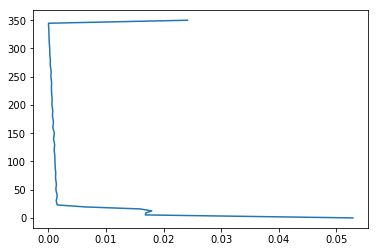

In [500]:
plt.plot(Model.u, Model.y_mom)

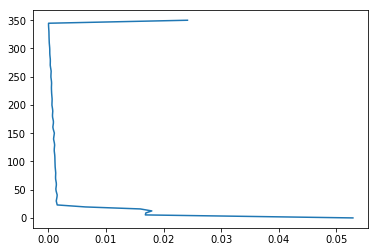

In [501]:
plt.plot(Model.v, Model.y_mom)

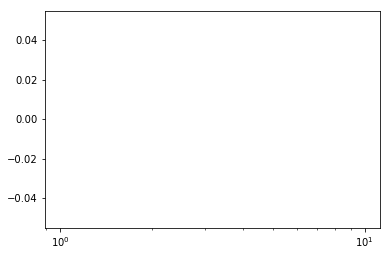

In [497]:
plt.plot(Model.nu_t, Model.y)
plt.xscale("log")

In [552]:
dp_x

array([  4.27261045e-03,  -4.85269627e-03,   1.89775656e-03,
        -2.50512042e-03,  -1.62479094e-03,   1.18123806e-04,
        -4.53789121e-03,   1.64024509e-04,  -1.87444322e-03,
         4.86535934e-04,  -1.11781880e-03,  -5.03055931e-04,
        -2.04794774e-03,   1.19236663e-03,  -2.69845204e-03,
        -2.51438808e-04,  -3.78496059e-03,  -6.74746857e-04,
         1.25004675e-03,  -3.75842933e-03,   5.08435356e-03,
        -6.02353743e-03,   3.56309133e-03,  -1.95382006e-03,
        -1.07577590e-03,  -4.64824879e-04,  -4.19507293e-03,
         1.31107018e-03,  -2.65090068e-03,   5.04364094e-04,
        -8.17221343e-04,  -1.44531576e-05])

In [553]:
dp_y

array([  2.39848114e-03,  -2.72411928e-03,   1.06532842e-03,
        -1.40627941e-03,  -9.12095887e-04,   6.63102158e-05,
        -2.54739968e-03,   9.20771262e-05,  -1.05224119e-03,
         2.73122784e-04,  -6.27500995e-04,  -2.82396483e-04,
        -1.14964003e-03,   6.69349314e-04,  -1.51480843e-03,
        -1.41148192e-04,  -2.12473304e-03,  -3.78777244e-04,
         7.01728740e-04,  -2.10983940e-03,   2.85416287e-03,
        -3.38138501e-03,   2.00018407e-03,  -1.09680033e-03,
        -6.03899711e-04,  -2.60935023e-04,  -2.35495452e-03,
         7.35984977e-04,  -1.48811490e-03,   2.83130836e-04,
        -4.58757006e-04,  -8.11345344e-06])

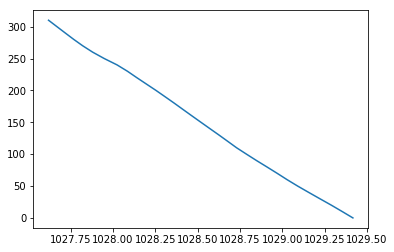

In [556]:
plt.plot(rho, depth)

In [305]:
0.03 * 5 * np.sqrt(2.5*1e-3)

0.0074999999999999997

In [307]:
Model.ustar

array([ 0.23353588,  0.00863166])